# TÉCNICAS DE APRENDIZAJE NO SUPERVISADO

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris, make_blobs
from sklearn.cluster import KMeans, MiniBatchKMeans, DBSCAN
from sklearn.metrics import silhouette_score, silhouette_samples
from matplotlib.ticker import FixedLocator, FixedFormatter
import PIL
from sklearn.datasets import load_digits
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_moons
from sklearn.neighbors import KNeighborsClassifier
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from matplotlib.colors import LogNorm


## EJEMPLO 1: KMeans

Antes de empezar vamos a crear un conjunto de datos:

In [2]:
blob_centers = np.array([[ 0.2,  2.3], [-1.5 ,  2.3], [-2.8,  1.8], [-2.8,  2.8], [-2.8,  1.3]])
blob_std = np.array([0.4, 0.3, 0.1, 0.1, 0.1])
X, y = make_blobs(n_samples=2000, centers=blob_centers, cluster_std=blob_std, random_state=7)

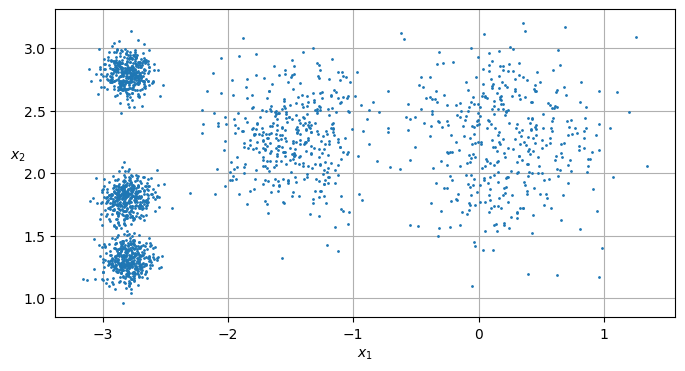

In [3]:
def plot_clusters(X, y=None):
    plt.scatter(X[:, 0], X[:, 1], c=y, s=1)
    plt.xlabel("$x_1$")
    plt.ylabel("$x_2$", rotation=0)

plt.figure(figsize=(8, 4))
plot_clusters(X)
plt.gca().set_axisbelow(True)
plt.grid()
plt.show()

Vamos a entrenar k-means en este conjunto de datos

In [4]:
k = 5
kmeans = KMeans(n_clusters=k, random_state=42)
y_pred = kmeans.fit_predict(X)

/opt/anaconda3/envs/sapa/lib/python3.12/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


In [5]:
y_pred

array([2, 2, 4, ..., 1, 4, 2], dtype=int32)

In [6]:
kmeans.cluster_centers_

array([[-0.066884  ,  2.10378803],
       [-2.79290307,  2.79641063],
       [-2.80214068,  1.55162671],
       [-1.47468607,  2.28399066],
       [ 0.47042841,  2.41380533]])

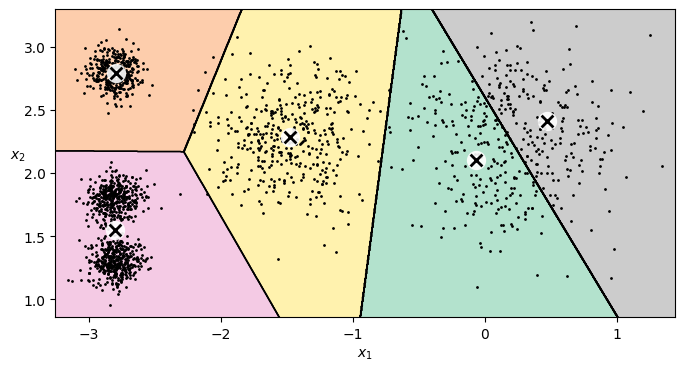

In [7]:
def plot_data(X):
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)

def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=35, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=2, linewidths=12,
                color=cross_color, zorder=11, alpha=1)

def plot_decision_boundaries(clusterer, X, resolution=1000, show_centroids=True, show_xlabels=True, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution), np.linspace(mins[1], maxs[1], resolution))
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]), cmap="Pastel2")
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]), linewidths=1, colors='k')
    plot_data(X)
    if show_centroids:
        plot_centroids(clusterer.cluster_centers_)

    if show_xlabels:
        plt.xlabel("$x_1$")
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", rotation=0)
    else:
        plt.tick_params(labelleft=False)

plt.figure(figsize=(8, 4))
plot_decision_boundaries(kmeans, X)
plt.show()

Podemos asignar con facilidad nuevas instancias al grupo cuyo centroide esté más cerca:

In [8]:
X_new = np.array([[0, 2], [3, 2], [-3, 3], [-3, 2.5]])
kmeans.predict(X_new)

array([0, 4, 1, 1], dtype=int32)

El método transform() mide la distancia desde cada instancia a todos los centroides

In [9]:
kmeans.transform(X_new).round(2)

array([[0.12, 2.9 , 2.84, 1.5 , 0.63],
       [3.07, 5.85, 5.82, 4.48, 2.56],
       [3.07, 0.29, 1.46, 1.69, 3.52],
       [2.96, 0.36, 0.97, 1.54, 3.47]])

Si tenemos una idea aproximada de dónde deberían estar los centroides, podemos establecer el hiperparámetro init como una matriz NumPy que contenga la lista de centroides y configurar n_init como 1

In [10]:
good_init = np.array([[-3, 3], [-3, 2], [-3, 1], [-1, 2], [0, 2]])
kmeans = KMeans(n_clusters=5, init=good_init, n_init=1, random_state=42)
kmeans.fit(X)

KMeans(init=array([[-3,  3],
       [-3,  2],
       [-3,  1],
       [-1,  2],
       [ 0,  2]]),
       n_clusters=5, n_init=1, random_state=42)

Pero ¿cómo saber exactamente cuál es la mejor solución? 

Podemos utilizar la denominada "inercia" del modelo, que es la suma de las distancias cuadráticas entre las instancias y sus centroides más próximos (cuanto menor mejor). 

In [11]:
kmeans.inertia_

211.59853725816836

El método score() devuelve la inercia negativa.

In [12]:
kmeans.score(X)

-211.5985372581684

## EJEMPLO 2: KMeans (encontrar el número de grupos óptimo))

Hasta ahora, hemos establecido el número de grupos k en 5 porque, viendo los datos, era evidente que ese era el número correcto de grupos, pero, en general, no será tan fácil saber cómo determinar k y el resultado puede ser bastante malo si configuramos un valor equivocado. 

In [13]:
kmeans_k3 = KMeans(n_clusters=3, random_state=42)
kmeans_k8 = KMeans(n_clusters=8, random_state=42)
kmeans_k3.fit(X)
kmeans_k8.fit(X)

KMeans(random_state=42)

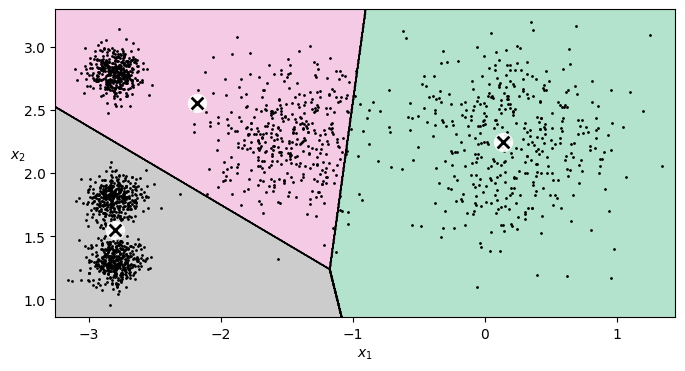

In [14]:
plt.figure(figsize=(8, 4))
plot_decision_boundaries(kmeans_k3, X)
plt.show()

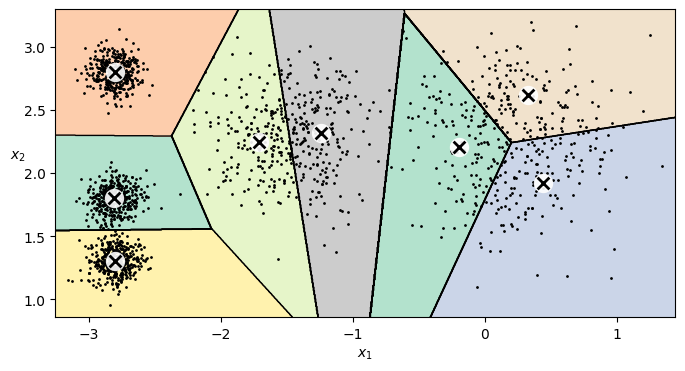

In [15]:
plt.figure(figsize=(8, 4))
plot_decision_boundaries(kmeans_k8, X)
plt.show()

In [16]:
kmeans_k3.inertia_

653.2167190021553

In [17]:
kmeans_k8.inertia_

127.13141880461836

La inercia para k = 3 es aproximadamente 653.2, que es mucho más alta que para k=5 (211.6). Pero, con k=8, la inercia es solo 119.1. La inercia no es una buena métrica de rendimiento cuando intentamos elegir k, porque sigue bajando a medida que incrementamos k. De hecho, cuantos más grupos haya, más cerca estará cada instancia de su centroide más próximo y, por tanto, menor será la inercia. 

Vamos a usar el coeficiente de la silueta. El coeficiente de silueta mide qué tan similar es un punto a su propio clúster en comparación con otros clústeres, proporcionando una evaluación de la cohesión y separación de los clústeres. Valores cercanos a 1 indican que los puntos están bien agrupados, mientras que valores cercanos a -1 indican que los puntos pueden estar en el clúster equivocado.

In [18]:
silhouette_score(X, kmeans.labels_)

0.655517642572828

In [19]:
silhouette_score(X, kmeans_k3.labels_)

0.5723900247411775

In [20]:
silhouette_score(X, kmeans_k8.labels_)

0.5458573941676348

Vamos a comparar las puntuaciones de la silueta para diferentes números de grupos.

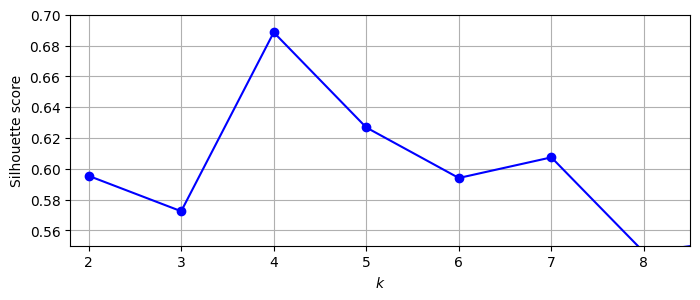

In [21]:
kmeans_per_k = [KMeans(n_clusters=k, random_state=42, n_init="auto").fit(X)for k in range(1, 10)]
silhouette_scores = [silhouette_score(X, model.labels_) for model in kmeans_per_k[1:]]

plt.figure(figsize=(8, 3))
plt.plot(range(2, 10), silhouette_scores, "bo-")
plt.xlabel("$k$")
plt.ylabel("Silhouette score")
plt.axis([1.8, 8.5, 0.55, 0.7])
plt.grid()
plt.show()

La figura indica que k = 4 es una opción muy buena, también resalta el hecho de que k = 5 es también bastante buena y mucho mejor que k = 6 o 7.

## EJEMPLO 3: Aprendizaje semisupervisado

En este tipo de agrupamientos tenemos un montón de instancias sin etiquetar y muy pocas instancias etiquetadas. 

Vamos a trabajar con el conjunto de datos digits, que es un conjunto de datos sencillo del estilo de MNIST que contiene 1797 imágenes en escala de grises que representan los dígitos del 0 al 9. 

Primero, vamos a cargar y dividir el conjunto de datos (ya está mezclado):

In [22]:
X_digits, y_digits = load_digits(return_X_y=True)
X_train, y_train = X_digits[:1400], y_digits[:1400]
X_test, y_test = X_digits[1400:], y_digits[1400:]

Vamos a fingir que solo tenemos etiquetas para 50 instancias. Para obtener un rendimiento de referencia, vamos a entrenar un modelo de regresión logística en estas 50 instancias etiquetadas:

In [23]:
n_labeled = 50
log_reg = LogisticRegression(max_iter=10_000)
log_reg.fit(X_train[:n_labeled], y_train[:n_labeled])

LogisticRegression(max_iter=10000)

In [24]:
log_reg.score(X_test, y_test)

0.7581863979848866

Vamos a agrupar el conjunto de entrenamiento en 50 grupos (usando k-means). Después, para cada grupo, buscaremos la imagen más cercana al centroide. Vamos a llamar a estas imágenes las "imágenes representativas":

In [25]:
k = 50
kmeans = KMeans(n_clusters=k, random_state=42)
X_digits_dist = kmeans.fit_transform(X_train)
representative_digit_idx = X_digits_dist.argmin(axis=0)
X_representative_digits = X_train[representative_digit_idx]

La siguiente figura muestra las 50 imágenes representativas.

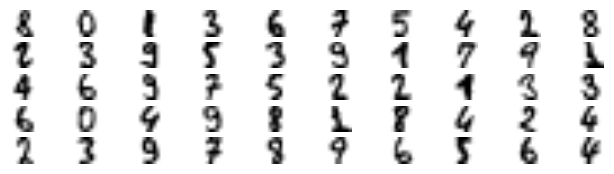

In [26]:
plt.figure(figsize=(8, 2))
for index, X_representative_digit in enumerate(X_representative_digits):
    plt.subplot(k // 10, 10, index + 1)
    plt.imshow(X_representative_digit.reshape(8, 8), cmap="binary", interpolation="bilinear")
    plt.axis('off')

plt.show()

Vamos a fijarnos en cada imagen y a etiquetarlas a mano:

In [27]:
y_representative_digits = np.array([
    8, 0, 1, 3, 6, 7, 5, 4, 1, 8,
    2, 3, 9, 5, 3, 9, 1, 7, 9, 1,
    4, 6, 9, 7, 5, 2, 2, 1, 3, 3,
    6, 0, 4, 9, 8, 1, 8, 4, 2, 4,
    2, 3, 9, 7, 8, 9, 6, 5, 6, 4
])

Ahora tenemos un conjunto de datos con solo 50 instancias etiquetadas, pero, en vez de ser instancias aleatorias, cada una de ellas es una imagen representativa de su grupo. Veamos si el rendimiento mejora:

In [28]:
log_reg = LogisticRegression(max_iter=10000)
log_reg.fit(X_representative_digits, y_representative_digits)
log_reg.score(X_test, y_test)

0.8387909319899244

Puesto que a menudo es costoso y difícil etiquetar instancias, sobre todo cuando tienen que hacerlo expertos a mano, es recomendable etiquetar instancias representativas, en vez de instancias aleatorias.

Pero podemos ir un paso más allá, podemos propagar las etiquetas a todas las demás instancias del mismo grupo ("propagación de etiquetas")

In [29]:
y_train_propagated = np.empty(len(X_train), dtype=np.int64)
for i in range(k):
    y_train_propagated[kmeans.labels_ == i] = y_representative_digits[i]

Ahora vamos a entrenar el modelo otra vez y a fijarnos en su rendimiento:

In [30]:
log_reg = LogisticRegression(max_iter=10000)
log_reg.fit(X_train, y_train_propagated)

LogisticRegression(max_iter=10000)

In [31]:
log_reg.score(X_test, y_test)

0.8337531486146096

## EJEMPLO 4: DBSCAN

Vamos a probar la clase DBSCAN en el conjunto de datos moons

In [32]:
X, y = make_moons(n_samples=1000, noise=0.05, random_state=42)
dbscan = DBSCAN(eps=0.05, min_samples=5)
dbscan.fit(X)

DBSCAN(eps=0.05)

Las etiquetas de todas las instancias están ahora disponibles en la variable de instancia labels_:

In [33]:
dbscan.labels_[:10]

array([ 0,  2, -1, -1,  1,  0,  0,  0,  2,  5])

Observa que algunas instancias tienen un índice de grupo igual a -1, lo que significa que el algoritmo las considera anomalías. 

Los índices de las instancias centrales están disponibles en la variable de instancia core_sample_indices_ y las propias instancias centrales están disponibles en la variable de instancia components_:

In [34]:
dbscan.core_sample_indices_[:10]

array([ 0,  4,  5,  6,  7,  8, 10, 11, 12, 13])

In [35]:
dbscan.components_

array([[-0.02137124,  0.40618608],
       [-0.84192557,  0.53058695],
       [ 0.58930337, -0.32137599],
       ...,
       [ 1.66258462, -0.3079193 ],
       [-0.94355873,  0.3278936 ],
       [ 0.79419406,  0.60777171]])

Esta agrupación se representa en el gráfico de la izquierda en la siguiente figura. Como vemos, ha identificado bastantes anomalías (las x rojas), además de siete grupos diferentes. Si ampliamos la vecindad de cada instancia incrementando eps a 0.2, obtenemos el agrupamiento de la derecha, que tiene un aspecto perfecto. 

In [36]:
dbscan2 = DBSCAN(eps=0.2)
dbscan2.fit(X)

DBSCAN(eps=0.2)

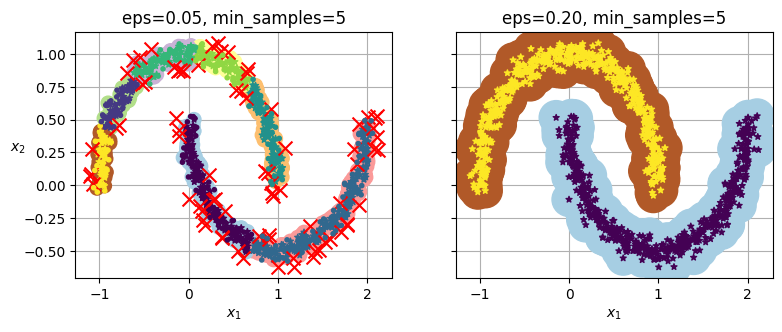

In [37]:
def plot_dbscan(dbscan, X, size, show_xlabels=True, show_ylabels=True):
    core_mask = np.zeros_like(dbscan.labels_, dtype=bool)
    core_mask[dbscan.core_sample_indices_] = True
    anomalies_mask = dbscan.labels_ == -1
    non_core_mask = ~(core_mask | anomalies_mask)

    cores = dbscan.components_
    anomalies = X[anomalies_mask]
    non_cores = X[non_core_mask]
    
    plt.scatter(cores[:, 0], cores[:, 1],
                c=dbscan.labels_[core_mask], marker='o', s=size, cmap="Paired")
    plt.scatter(cores[:, 0], cores[:, 1], marker='*', s=20,
                c=dbscan.labels_[core_mask])
    plt.scatter(anomalies[:, 0], anomalies[:, 1],
                c="r", marker="x", s=100)
    plt.scatter(non_cores[:, 0], non_cores[:, 1],
                c=dbscan.labels_[non_core_mask], marker=".")
    if show_xlabels:
        plt.xlabel("$x_1$")
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", rotation=0)
    else:
        plt.tick_params(labelleft=False)
    plt.title(f"eps={dbscan.eps:.2f}, min_samples={dbscan.min_samples}")
    plt.grid()
    plt.gca().set_axisbelow(True)

plt.figure(figsize=(9, 3.2))

plt.subplot(121)
plot_dbscan(dbscan, X, size=100)

plt.subplot(122)
plot_dbscan(dbscan2, X, size=600, show_ylabels=False)
plt.show()

Vamos a continuar con el modelo de la derecha.

In [38]:
dbscan = dbscan2 

La clase DBSCAN no tiene método predict(), pero tiene un método fit_predict(). Dicho de otro modo, hay que usarlo con otro algoritmo de clasificación. Por ejemplo, vamos a entrenar un KNeighborsClassifier:

In [39]:
knn = KNeighborsClassifier(n_neighbors=50)
knn.fit(dbscan.components_, dbscan.labels_[dbscan.core_sample_indices_])

KNeighborsClassifier(n_neighbors=50)

Ahora, si nos dan algunas instancias nuevas, podemos predecir a qué grupos es más probable que pertenezcan e incluso estimar una probabilidad para cada grupo:

In [40]:
X_new = np.array([[-0.5, 0], [0, 0.5], [1, -0.1], [2, 1]])
knn.predict(X_new)

array([1, 0, 1, 0])

In [41]:
knn.predict_proba(X_new)

array([[0.18, 0.82],
       [1.  , 0.  ],
       [0.12, 0.88],
       [1.  , 0.  ]])

Ten en cuenta que solo hemos entrenado el clasificador en las instancias centrales, pero podríamos haber elegido entrenarlo en todas las instancias o en todas menos en las anomalías: esta elección depende de la tarea final.

## EJEMPLO 5: GaussianMixture

Primero vamos a crear los datos para nuestro ejemplo:

In [42]:
X1, y1 = make_blobs(n_samples=1000, centers=((4, -4), (0, 0)), random_state=42)
X1 = X1.dot(np.array([[0.374, 0.95], [0.732, 0.598]]))
X2, y2 = make_blobs(n_samples=250, centers=1, random_state=42)
X2 = X2 + [6, -8]
X = np.r_[X1, X2]
y = np.r_[y1, y2]

Vamos a visualizar los datos generados

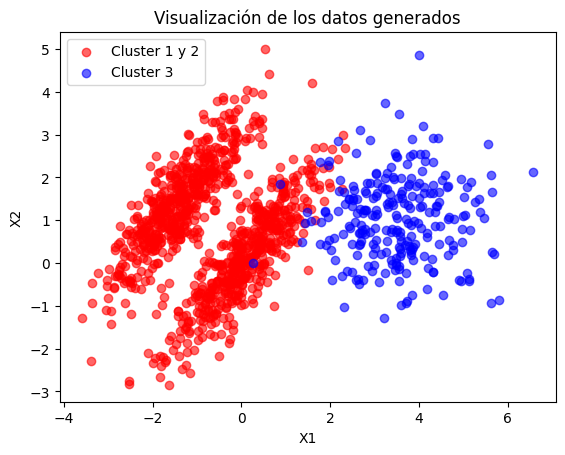

In [43]:
plt.scatter(X1[:, 0], X1[:, 1], c='red', label='Cluster 1 y 2', alpha=0.6)
plt.scatter(X2[:, 0], X2[:, 1], c='blue', label='Cluster 3', alpha=0.6)
plt.title('Visualización de los datos generados')
plt.xlabel('X1')
plt.ylabel('X2')
plt.legend()
plt.show()

Ahora aplicamos la clase GaussianMixture

In [44]:
gm = GaussianMixture(n_components=3, n_init=10, random_state=42)
gm.fit(X)

GaussianMixture(n_components=3, n_init=10, random_state=42)

Vamos a fijarnos en los parámetros que ha estimado el algoritmo:

In [45]:
gm.weights_

array([0.40005972, 0.20961444, 0.39032584])

In [46]:
gm.means_

array([[-1.40764129,  1.42712848],
       [ 3.39947665,  1.05931088],
       [ 0.05145113,  0.07534576]])

Utilizamos el método predict() para el agrupamiento duro o el método predict_proba() para el agrupamiento suave:

In [47]:
gm.predict(X)

array([2, 2, 0, ..., 1, 1, 1])

In [48]:
gm.predict_proba(X).round(3)

array([[0.   , 0.023, 0.977],
       [0.001, 0.016, 0.983],
       [1.   , 0.   , 0.   ],
       ...,
       [0.   , 1.   , 0.   ],
       [0.   , 1.   , 0.   ],
       [0.   , 1.   , 0.   ]])

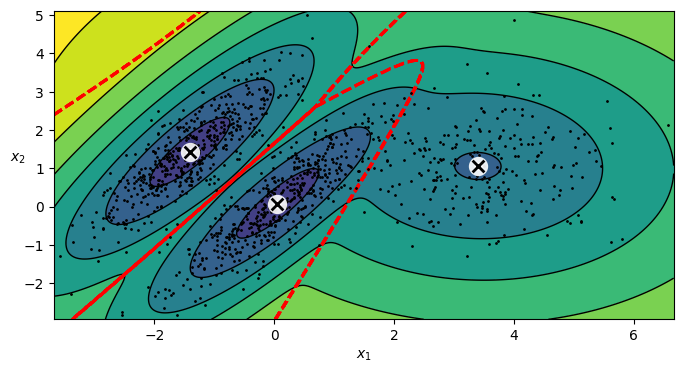

In [49]:
def plot_gaussian_mixture(clusterer, X, resolution=1000, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = -clusterer.score_samples(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z,
                 norm=LogNorm(vmin=1.0, vmax=30.0),
                 levels=np.logspace(0, 2, 12))
    plt.contour(xx, yy, Z,
                norm=LogNorm(vmin=1.0, vmax=30.0),
                levels=np.logspace(0, 2, 12),
                linewidths=1, colors='k')

    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z,
                linewidths=2, colors='r', linestyles='dashed')
    
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)
    plot_centroids(clusterer.means_, clusterer.weights_)

    plt.xlabel("$x_1$")
    if show_ylabels:
        plt.ylabel("$x_2$", rotation=0)
    else:
        plt.tick_params(labelleft=False)

plt.figure(figsize=(8, 4))

plot_gaussian_mixture(gm, X)

plt.show()

Al igual que k-meas, el algoritmo GaussianMixture requiere que especifiquemos el número de grupos. Con las mezclas gaussianas, podemos intentar encontrar el modelo que minimice un criterio de información teórica, como el criterio de información bayesiano (BIC) o el criterio de información de Akaike (AIC)

In [50]:
gm.bic(X)

8189.733705221638

In [51]:
gm.aic(X)

8102.5084251066

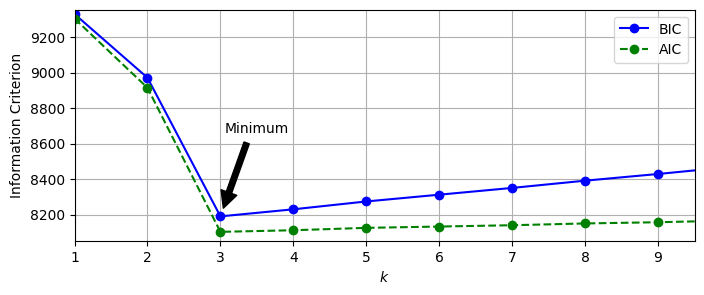

In [52]:
gms_per_k = [GaussianMixture(n_components=k, n_init=10, random_state=42).fit(X)
             for k in range(1, 11)]
bics = [model.bic(X) for model in gms_per_k]
aics = [model.aic(X) for model in gms_per_k]

plt.figure(figsize=(8, 3))
plt.plot(range(1, 11), bics, "bo-", label="BIC")
plt.plot(range(1, 11), aics, "go--", label="AIC")
plt.xlabel("$k$")
plt.ylabel("Information Criterion")
plt.axis([1, 9.5, min(aics) - 50, max(aics) + 50])
plt.annotate("", xy=(3, bics[2]), xytext=(3.4, 8650),
             arrowprops=dict(facecolor='black', shrink=0.1))
plt.text(3.5, 8660, "Minimum", horizontalalignment="center")
plt.legend()
plt.grid()

plt.show()

La figura muestra el BIC y AIC para diferentes números de grupos k. Tanto el BIC como el AIC son más bajos cuando k = 3, así que es probable que esa sea la mejor opción.